# Логистическая регрессия и случайный лес, домашнее задание

## Обзор

В задании вам предстоит на простом примере познакомиться с базовыми инструментами построения логистической регрессии:
* визуализация
* разбиение данных на обучающую и тестовую выборки
* преобразование переменных
* отбор переменных
* $L1$ и $L2$ регуляризации
* построение итоговой модели и валидация

Далее вы построите случайный лес и сравните два класса моделей.

Все это будет на сгенерированных данных.
Примеры многих функций уже есть в коде, остальное можно посмотреть в официальных документациях или просто поискать в интернете примеры применения.

Оценка будет выставляться с учетом первых трех заданий, третье опционально

## Сгенерируем данные

In [145]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

X, y = make_classification(n_samples=7000, n_features=20, n_informative=5, n_redundant=2,
                           n_repeated=0, scale=None, shift=None, shuffle=False, class_sep=0.5, 
                           random_state=40)

**Комментарий для меня**
Всего два класса, фич 20, среди них: 5 информативных, 2 излишних.

Разбивка на train и test нужна для того, чтобы оставить часть данных нетронутой для проверки

Модель мы будем применять на данных, которые еще не видели, и разбивка позволяет нам хоть немного имитировать этот процесс

Если хотим использовать методы, требующие ручного подбора параметров (например, коэффициента регуляризации), можно выделить еще третий вид выборки — валидационную или validation. Подбор параметров традиционно выглядит так:
1. задаем параметр;
2. обучаем модель на train;
3. смотрим на качество предсказания на validation;
4. снова задаем параметр, возвращаемся к п.2;
5. ищем максимум качества на валидации;
6. выбираем параметры, которые лучше всего себя показали на validation, обучаем еще раз модель, проверяем итоги на test.

Если ручных параметров нет, можно делить выборку на 2 части — train, test

Выборка бьется последовательным применением train_test_split

Стандартные пропорции: 70:30 в случае с train/test, 60:20:20 в случае с train/val/test

In [146]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## Можно визуализировать зависимости, посмотреть на характер данных

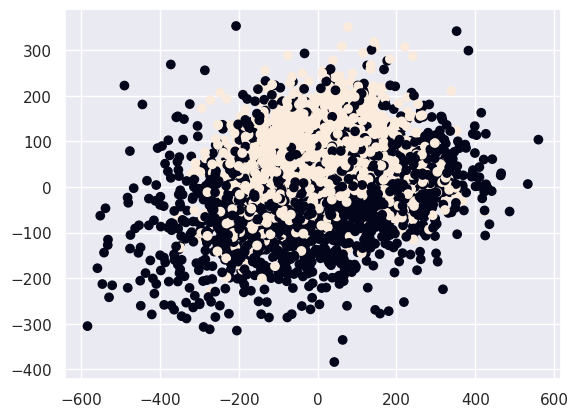

In [147]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
plt.show()

Первично анализировать признаки удобно с помощью woe_line.

Функция делит наблюдения на группы по $X$, для каждой группы считает WoE, и откладывает эти значения на графике.

Можно встретить определение WoE, отличающееся знаком, на анализ и выводы это не влияет

# Анализ данных

## Подготовка

## Задание 1

Написать функцию woe_line:

1. разбить наблюдения на n_buckets групп по $X$
2. в каждой группе по y отложить WoE, по x медианное значение $X$
3. вывести полученный график
4. вывести ROC AUC признака (sklearn.metrics.roc_auc_score)
5. Опционально. Рассчитать доверительный интервал для bad rate (bad rate - доля наблюдений с целевой переменной =1 от всех наблюдений в группе)
6. Опционально. Нанести на график линейное приближение любым способом

График позволит проверить линейность зависимости, силу переменной, опционально проверить распределение

In [148]:
import seaborn as sns
sns.set_theme(style="darkgrid")
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LinearRegression

In [149]:
def woe_line(X,         # 1-d array with independent feature 
             y,         # 1-d array with target feature
             n_buckets=10, # number of buckets to plot
             var_nm="var_name",    # optional, var_name to show above the plot
             target_nm="target_name", # optional, target_name to show above the plot
             plot_hist=False  # optional, if True — histogram of X is displayed
            ):
    global_woe = np.log(sum(y)/(y.shape[0] - sum(y)))
    X, y = (list(t) for t in zip(*sorted(zip(X, y))))
    buckets_X = np.array_split(X, n_buckets)
    buckets_y = np.array_split(y, n_buckets)
    graph_X = [np.median(bucket) for bucket in buckets_X]
    graph_Y = []
    for bucket in buckets_y:
        woe = np.log(sum(bucket) / (bucket.shape[0] - sum(bucket))) - global_woe
        graph_Y.append(woe)
    ROC_AUC = roc_auc_score(y, X)
    model = LinearRegression()
    model.fit(np.array(graph_X).reshape((-1,1)), np.array(graph_Y).reshape((-1,1)))
    lin_Y = model.predict(np.array(graph_X).reshape((-1,1)))
    title = var_nm + " | " + target_nm + " ROC AUC = " + str(round(ROC_AUC, 3))
    fig, ax1 = plt.subplots(figsize=(12, 5))
    ax1.plot(graph_X, lin_Y,color='#5775c9', linewidth=1.5, label="Interpolation")
    ax1.set_xlabel("Feature value")
    ax1.set_ylabel("WoE")
    ax1.plot(graph_X, graph_Y, color='red', linestyle='--', marker='o', markersize=3, linewidth=0.6, label="WoE")
    plt.legend()
    plt.title(title)
    if (plot_hist):
        ax2= ax1.twinx()
        ax2.set_ylabel("Count")
        ax2.hist(X, alpha=0.3)
        ax2.grid(False)
    fig.tight_layout()
    plt.show()

На примере функция дополнительно отображает $R^2$ — меру линейности зависимости, а также линию, показывающую линейное приближение

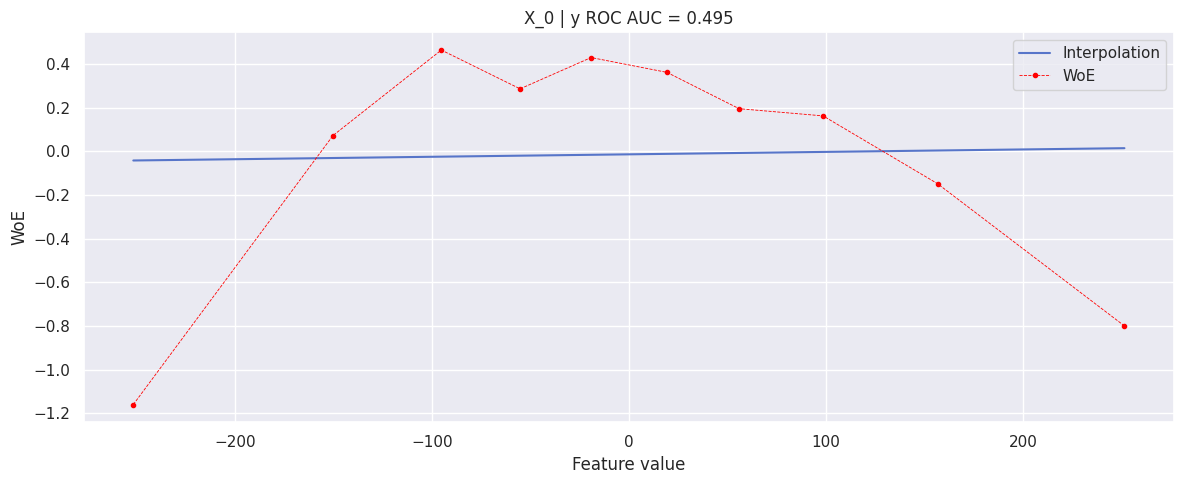

In [150]:
woe_line(X_train[:, 0],y_train, n_buckets=10, var_nm="X_0", target_nm="y", plot_hist=False)

## Анализ каждой переменной

В ячейке ниже пример функции и результата ее выполнения на других данных. Сам график может быть отрисован чуть иначе или в другой библиотеке, главное — сохранить суть

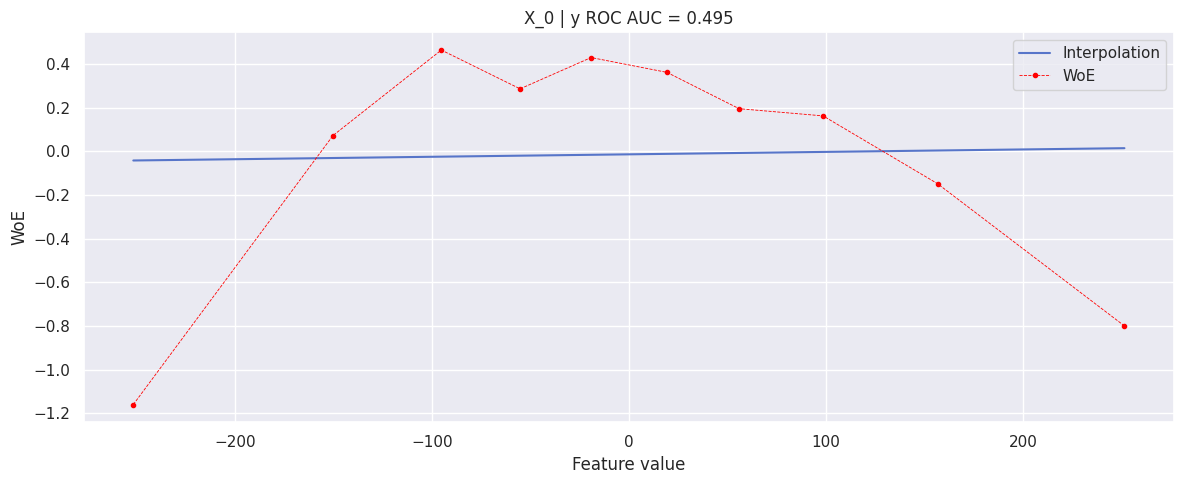

In [151]:
res = woe_line(X_train[:, 0], y_train, n_buckets=10, plot_hist=False, 
               var_nm = 'X_0', target_nm = 'y')

Видно, что переменная разделяет целевую переменную примерно до значения 0, дальше кривая выходит на плато. Можно ограничить этот хвост, чтобы не закладывать разделение в модель

Можно сразу в woe_line передавать преобразованную переменную, важно потом при проверках модели на test не забыть сделать то же преобразование

Для борьбы с выбросами можно также ограничивать длинные хвосты распределения. Особенно это полезно в реальном применении модели, чтобы ограничить влияние одной переменной на предсказание всей модели

При преобразовании переменных важно соблюдать баланс:

1. переменная должна стать линейной,
2. не стоит доводить до идеальной линейности в ущерб разделяющей силы (ROC AUC),
3. в работе с реальными данными стоит обращать внимание на физический смысл переменных. Например, в случае с размерными переменными (рубли, метры), часто помогает взятие корня или логарифма, а еще лучше приводить их к безразмерным величинам нормировкой.

## Задание 2

1. проверить каждую переменную на woe_line,
2. каждую полезную переменную линеаризовать (для каждой переменной нужны графики ДО и ПОСЛЕ),
3. ненужные переменные (слабые по ROC AUC, немонотонные) исключить из модели,
4. на отобранных и линеаризованных переменных построить модель, проверить результат на test по ROC AUC.

Подробно про обучение моделей можно почитать в официальной документации, там же есть примеры использования

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

# Построение логистической регрессии

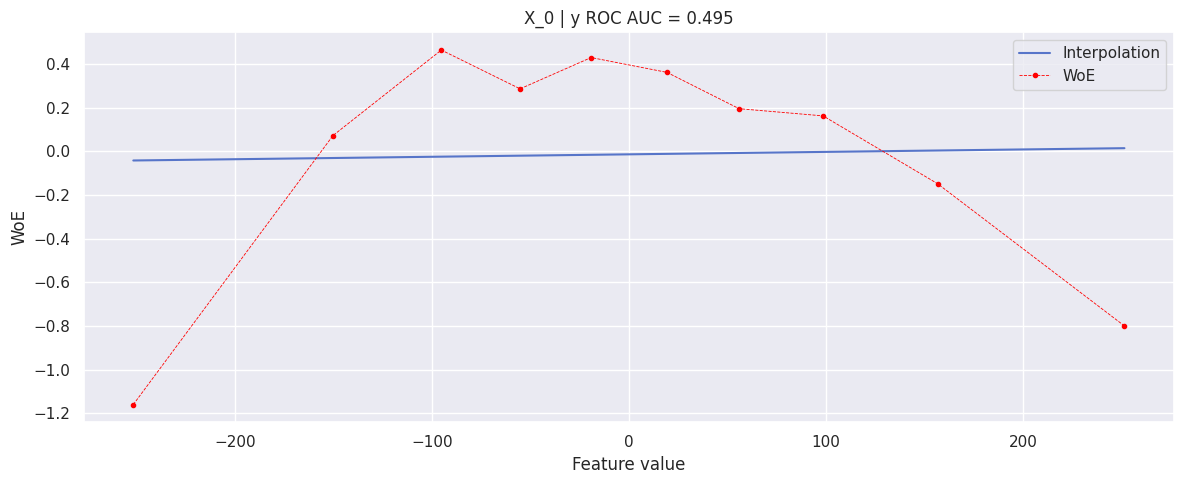

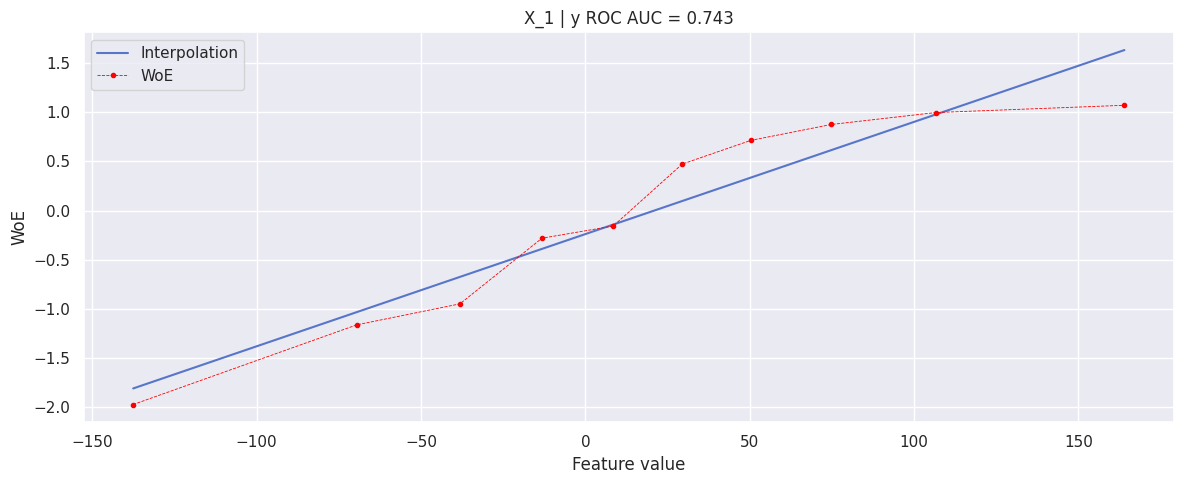

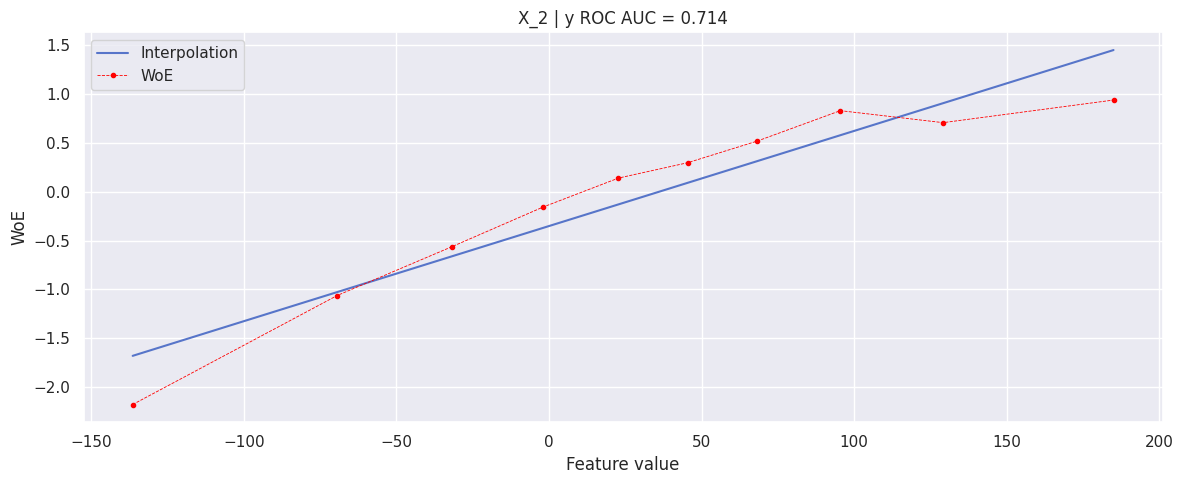

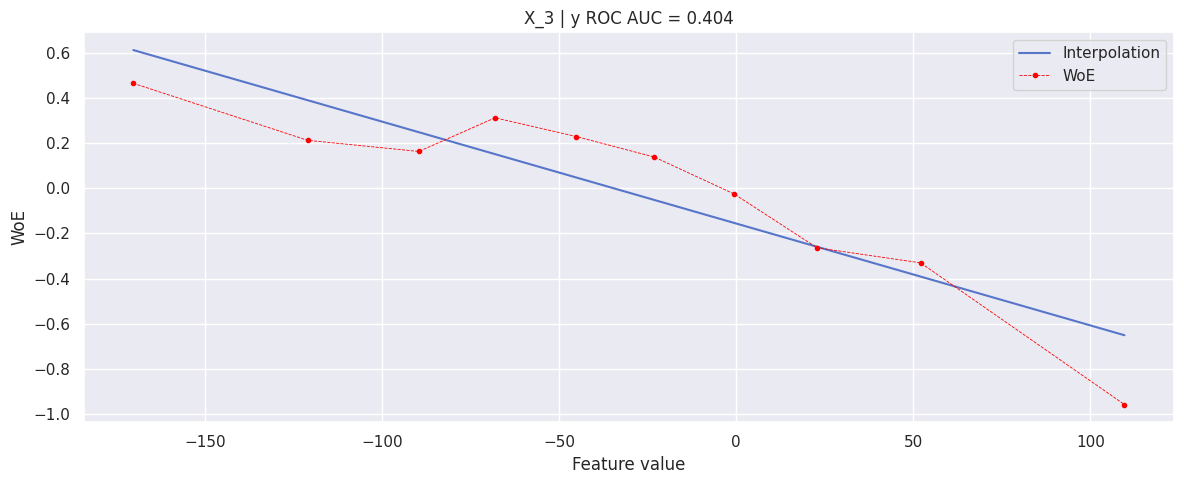

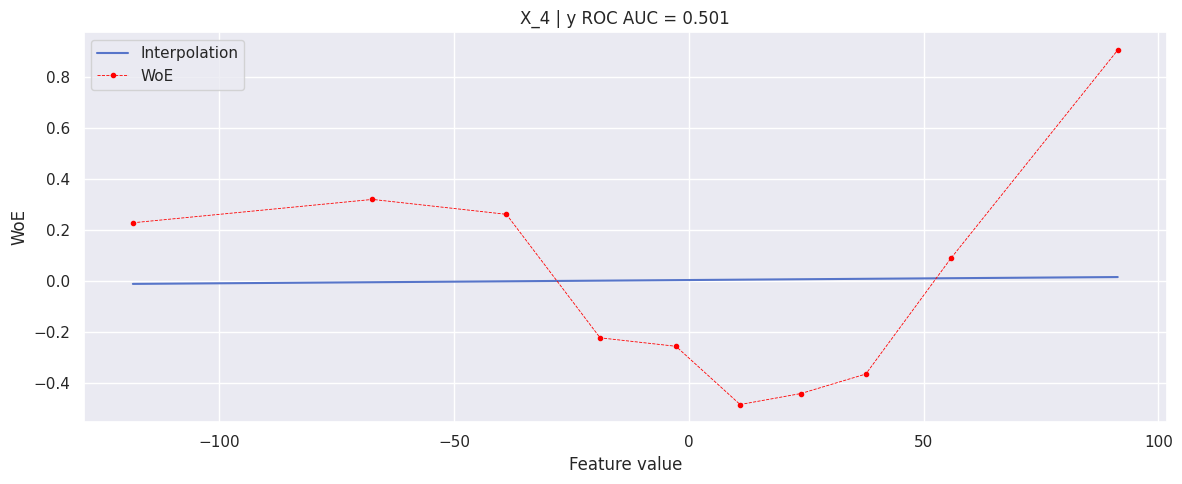

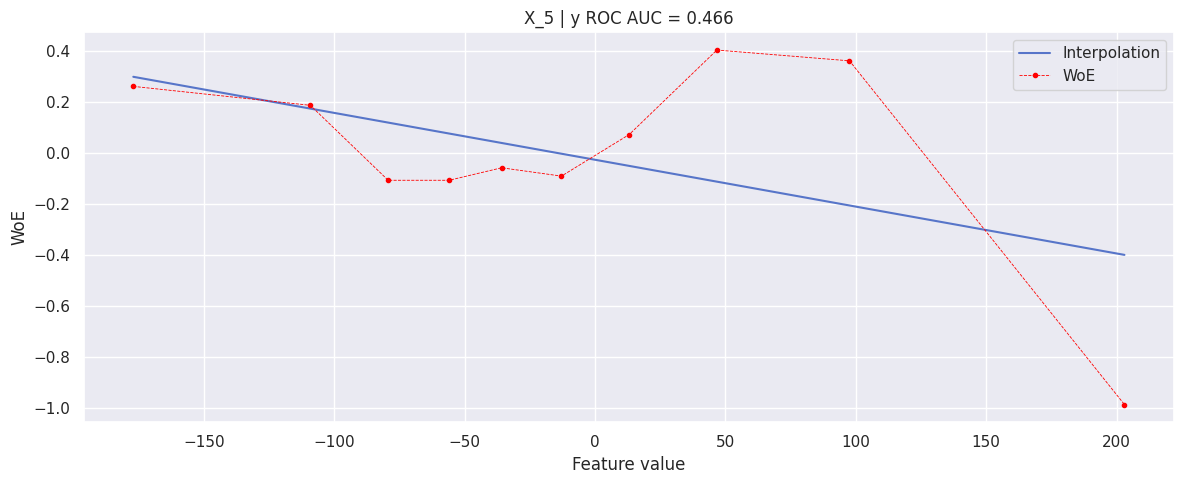

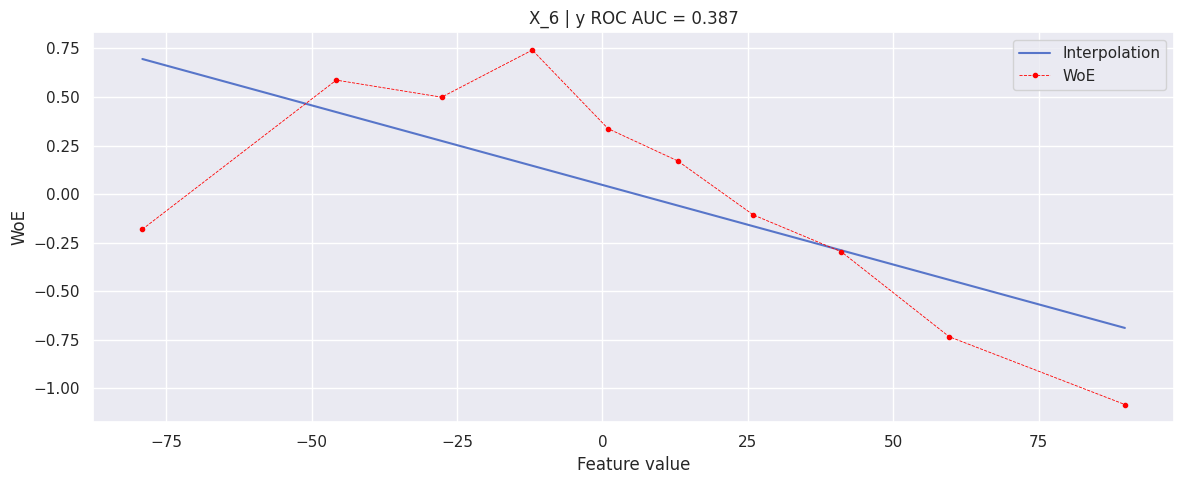

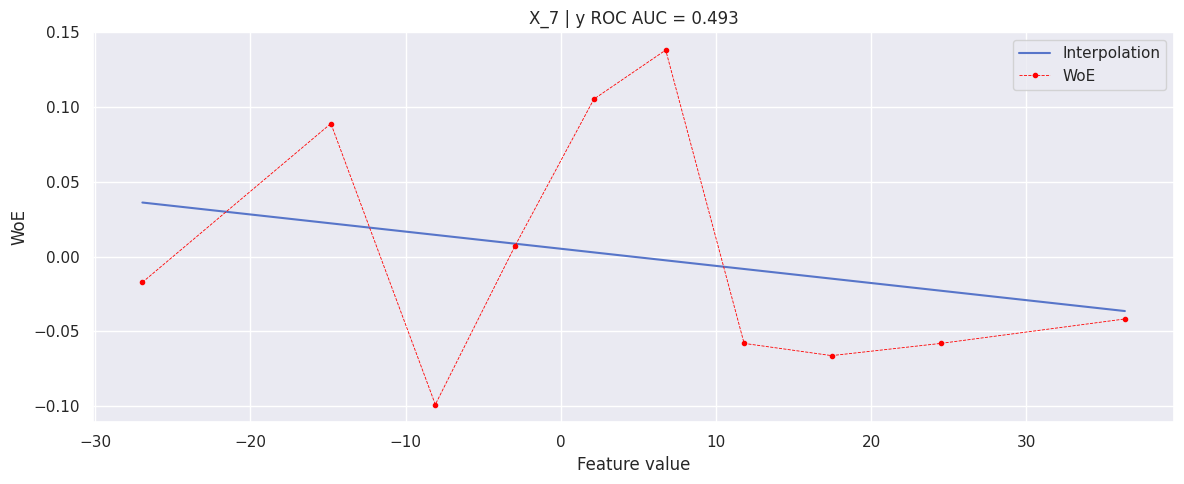

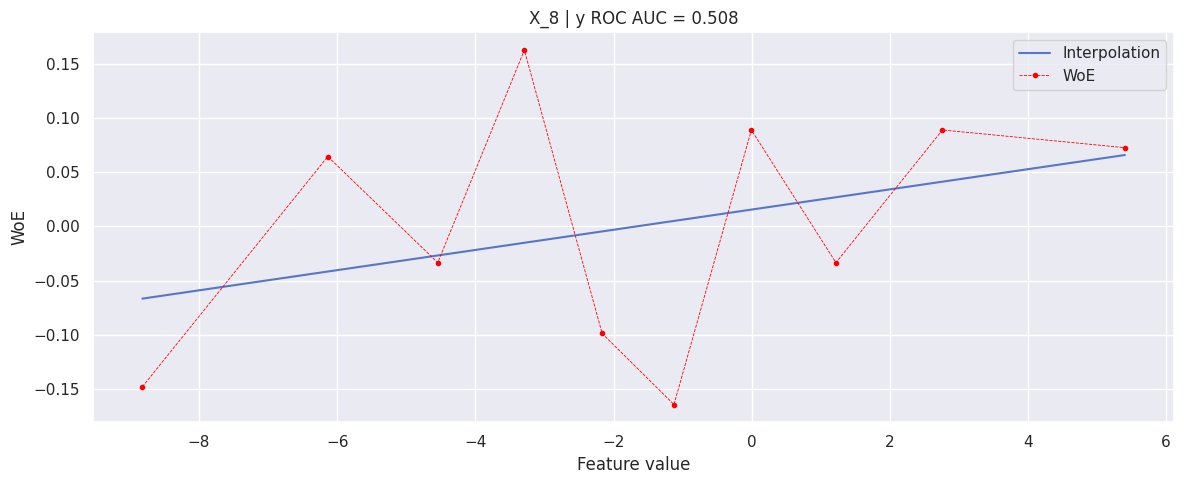

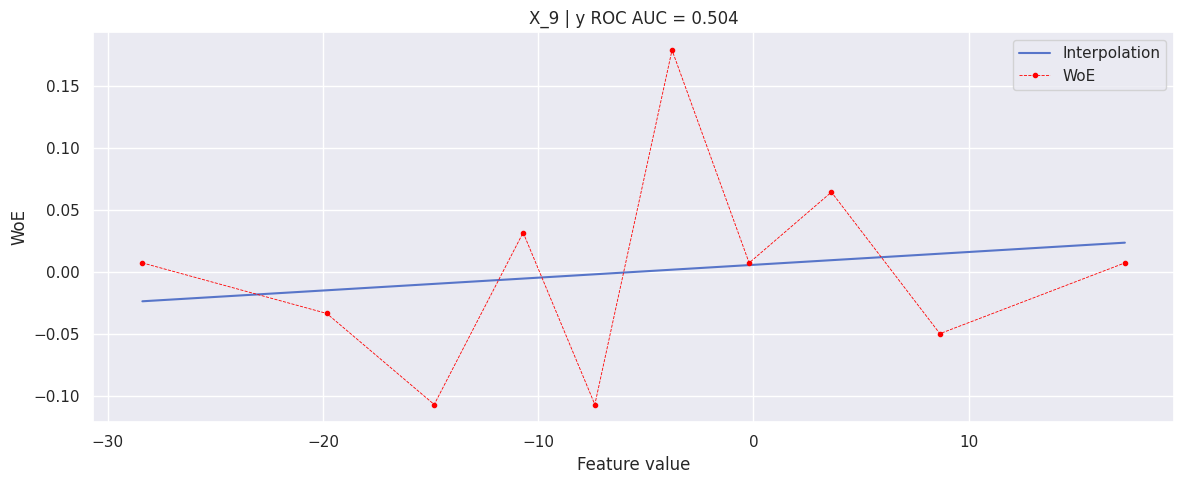

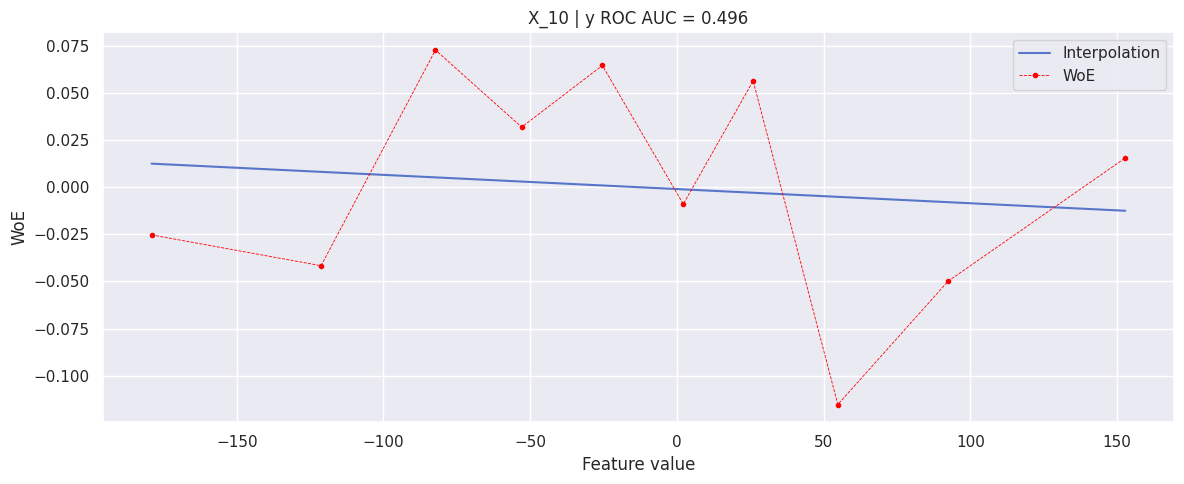

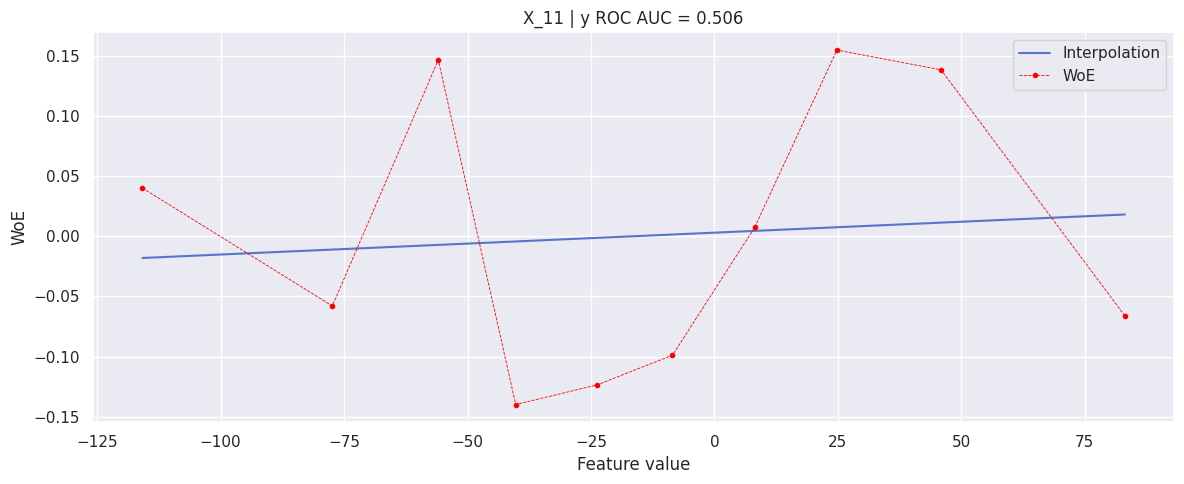

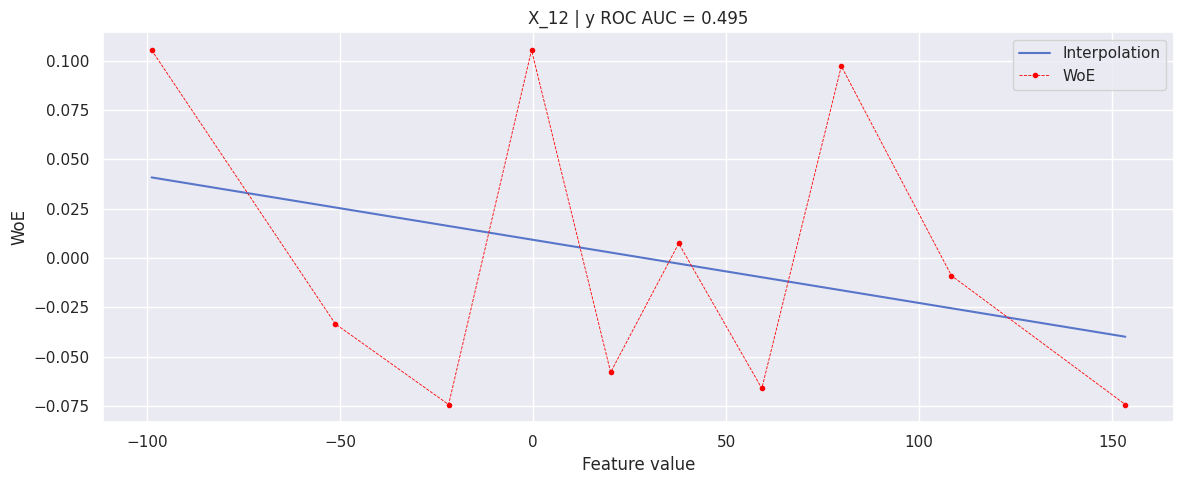

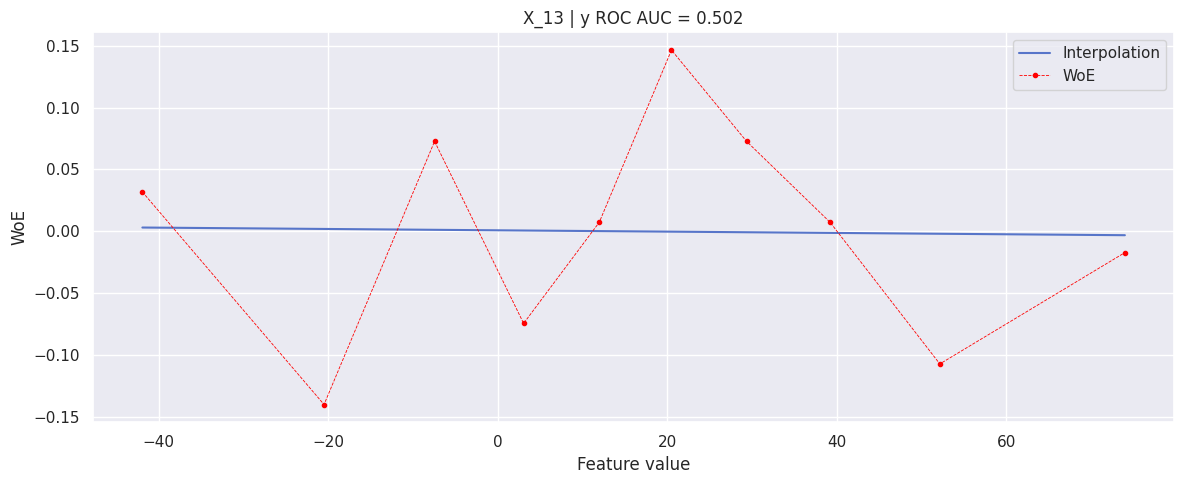

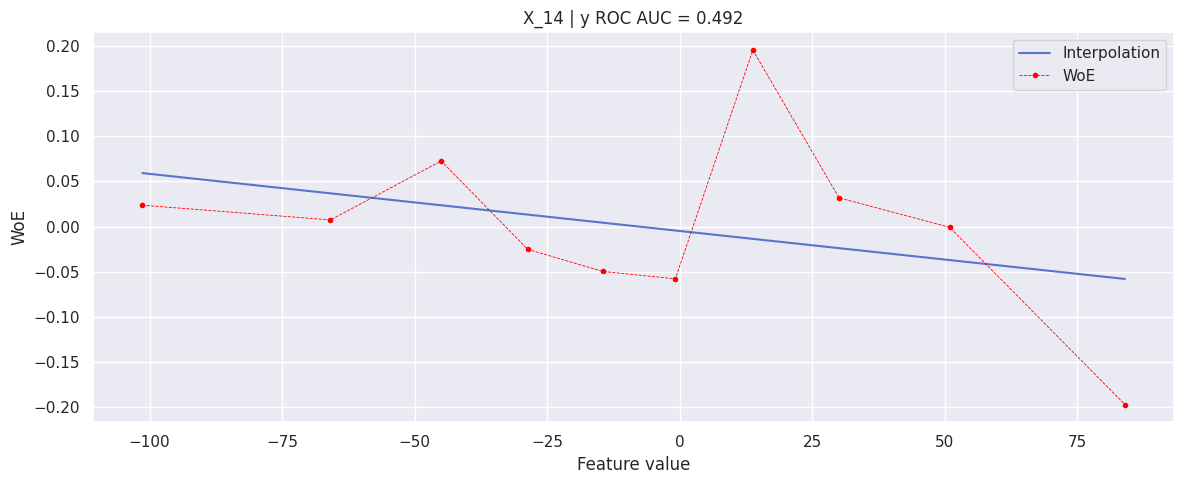

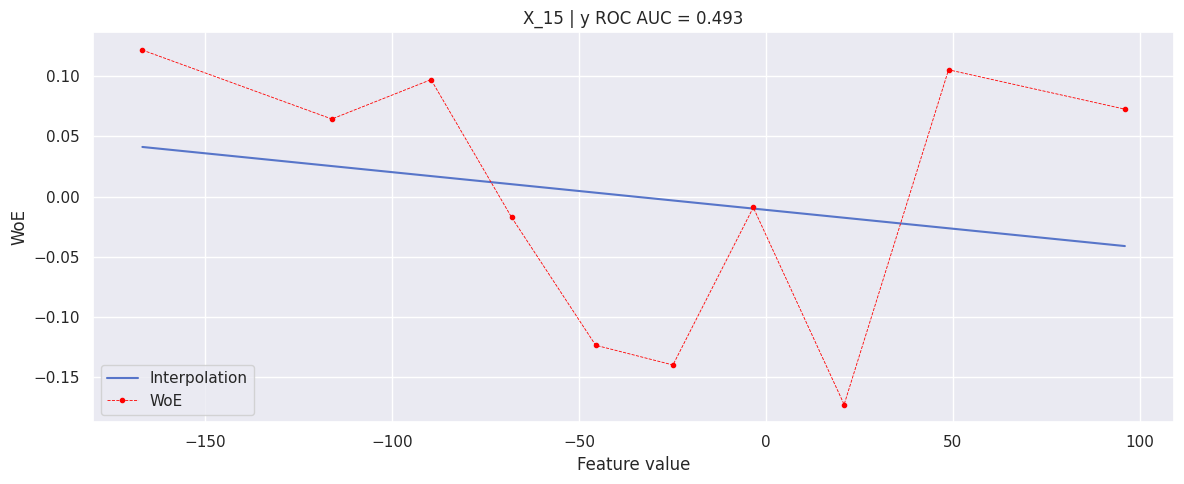

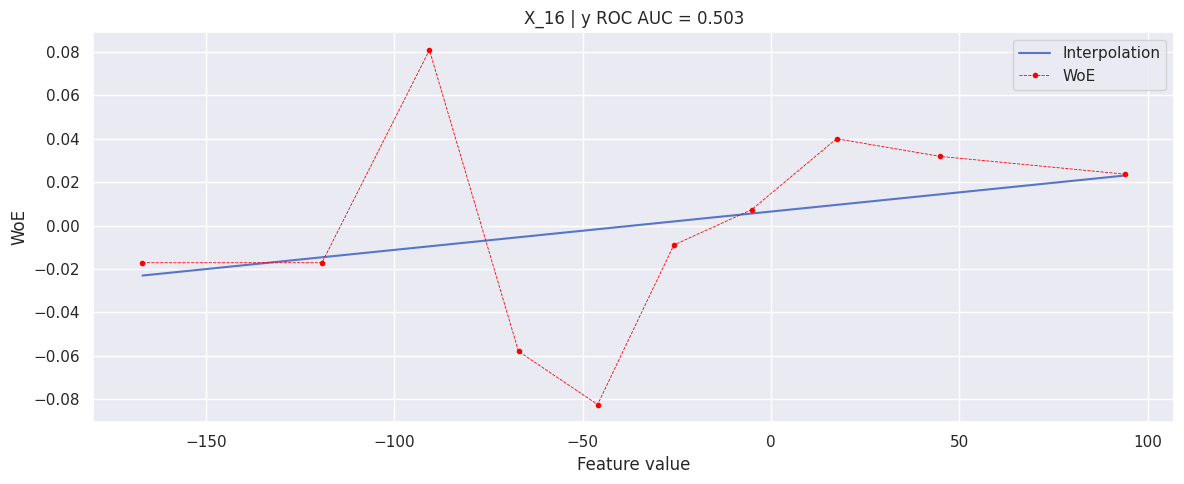

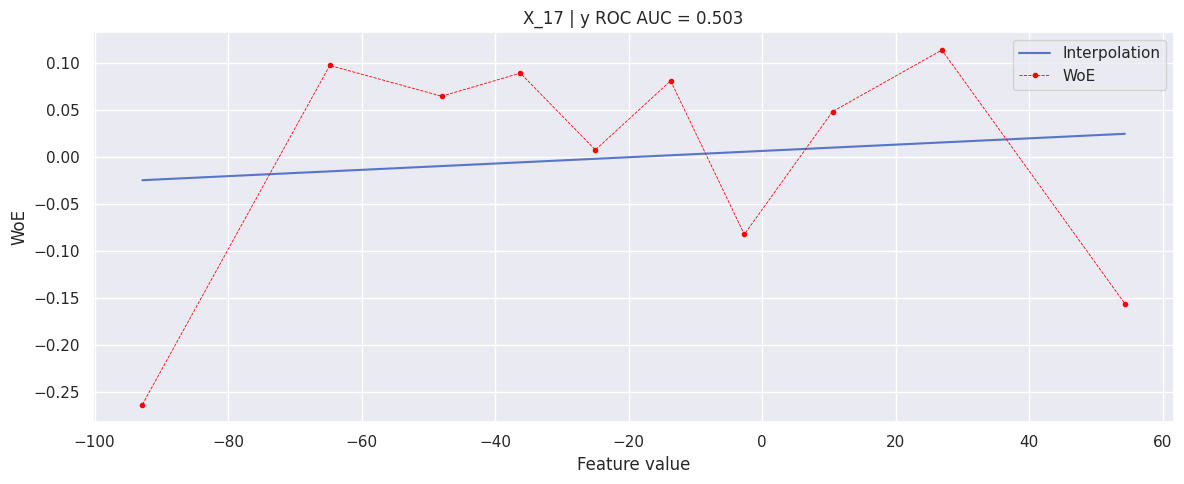

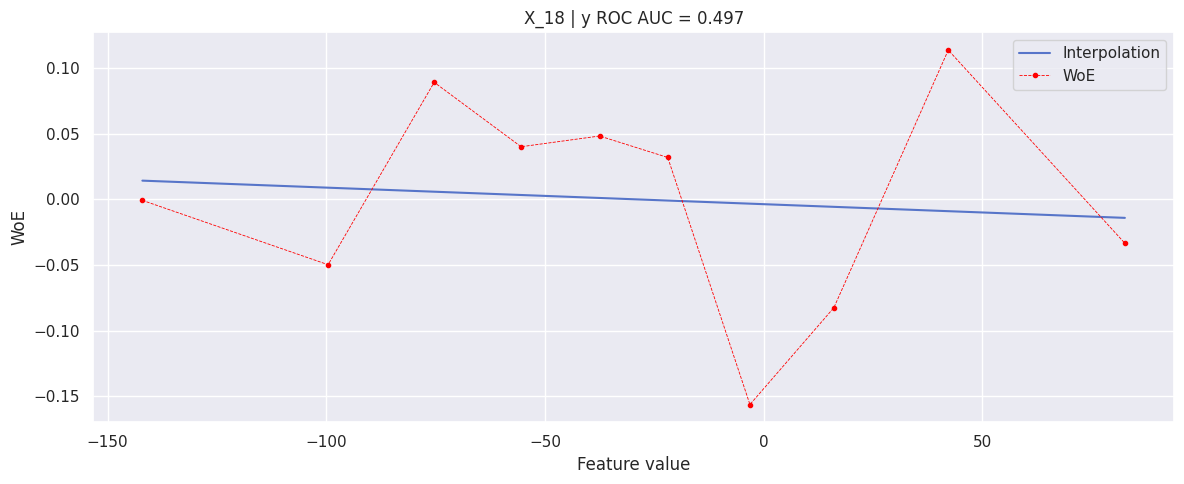

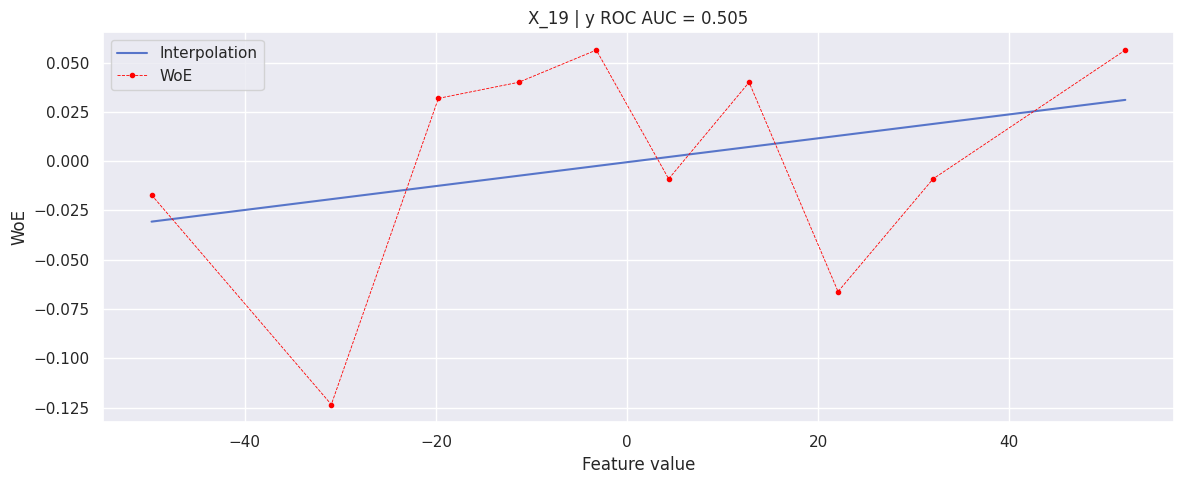

In [169]:
for i in range(0, 20):
    woe_line(X_train[:, i],y_train, n_buckets=10, var_nm="X_" + str(i), target_nm="y", plot_hist=False)

По ROC_AUC и WoE-line можно предположить, что все фичи, кроме номеров 1,2,3,5,6 скорее всего НЕ информативные.
Убедимся в этом, непосредственно сравнив значение ROC_AUC с половиной:

In [153]:
non_informative = []

for i in range(X.shape[1]):
    auc = roc_auc_score(y, X[:, i])

    if abs(auc - 0.5) < 0.02:
        print(f"{i} : {auc = :.3f} -> non_informative")
        non_informative.append(i)

    else:
        print(f"{i} : {auc = :.3f}")

0 : auc = 0.491 -> non_informative
1 : auc = 0.736
2 : auc = 0.708
3 : auc = 0.406
4 : auc = 0.502 -> non_informative
5 : auc = 0.471
6 : auc = 0.389
7 : auc = 0.490 -> non_informative
8 : auc = 0.508 -> non_informative
9 : auc = 0.507 -> non_informative
10 : auc = 0.502 -> non_informative
11 : auc = 0.501 -> non_informative
12 : auc = 0.495 -> non_informative
13 : auc = 0.500 -> non_informative
14 : auc = 0.486 -> non_informative
15 : auc = 0.504 -> non_informative
16 : auc = 0.501 -> non_informative
17 : auc = 0.514 -> non_informative
18 : auc = 0.500 -> non_informative
19 : auc = 0.502 -> non_informative


Линеаризируем информативные features. Номера 1,2 и 3 уже выглядят неплохо. Для них можно попробовать обрубить концы. А вот по номерам 5 и 6 работаем "серьезно".

In [217]:
X_train_prep = np.copy(X_train)
X_test_prep = np.copy(X_test)

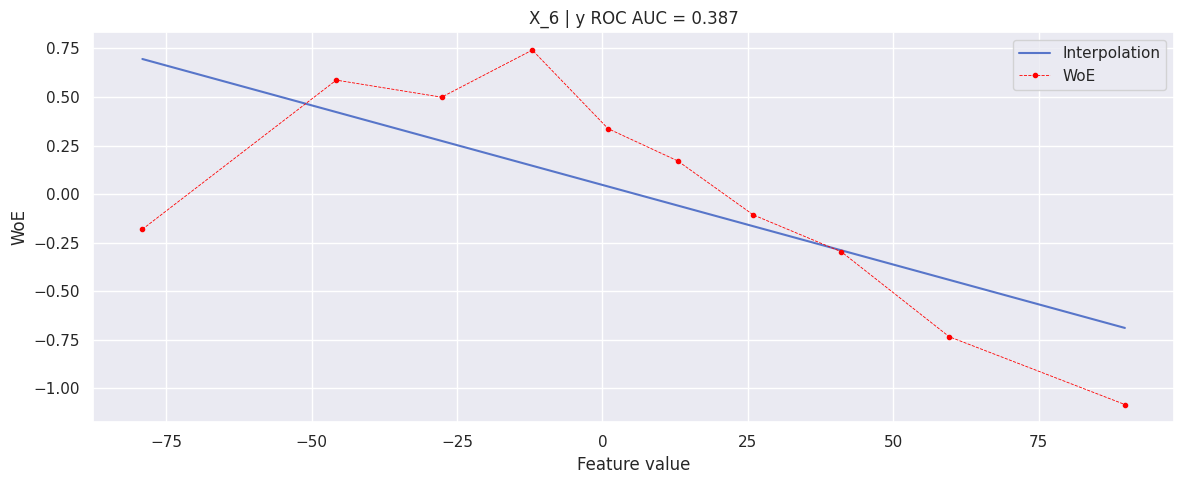

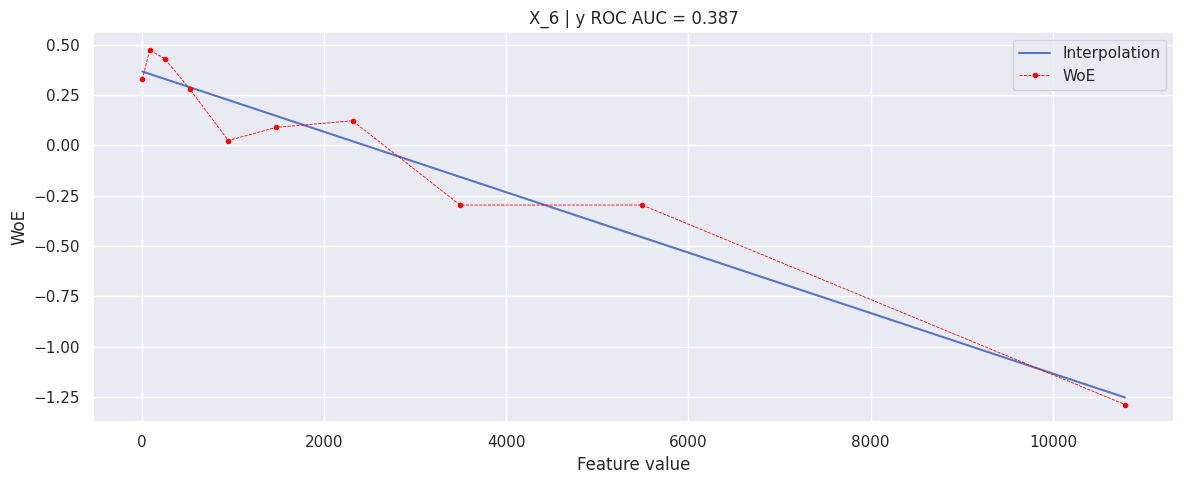

In [218]:
woe_line(X_train_prep[:, 6],y_train, n_buckets=10, var_nm="X_6", target_nm="y", plot_hist=False)
for x in X_train_prep:
    x[6] = x[6]*x[6]
woe_line(X_train_prep[:, 6],y_train, n_buckets=10, var_nm="X_6", target_nm="y", plot_hist=False)

Возведение в квадрат 6-ого признака неплохо его линеаризовало. Применим такое же преобразование и для тестовых признаков.

In [219]:
for x in X_test_prep:
    x[6] = x[6]*x[6]

Попробуем справиться с номером 5.

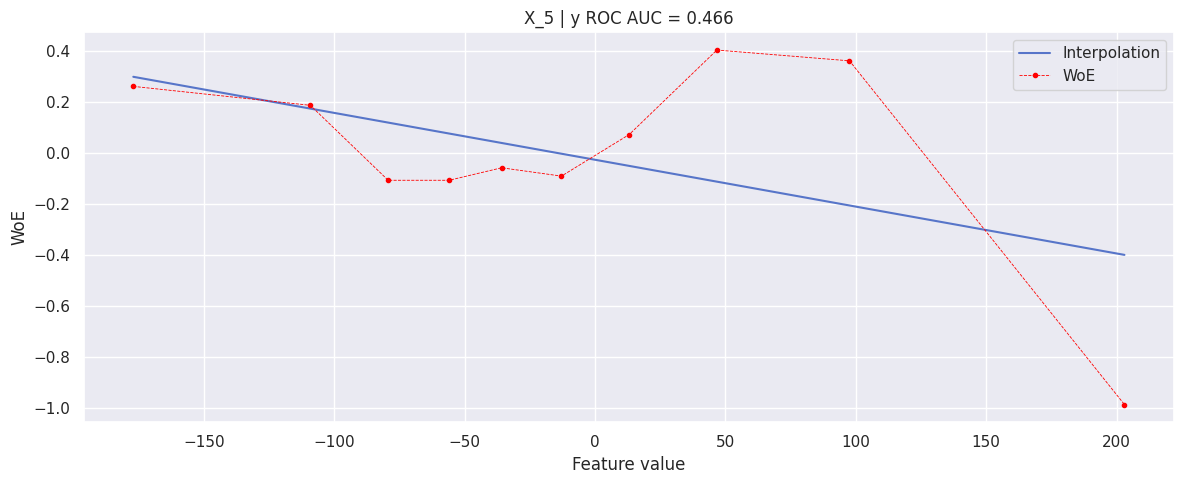

In [173]:
woe_line(X_train_prep[:, 5],y_train, n_buckets=10, var_nm="X_5", target_nm="y", plot_hist=False)

In [215]:
for x in X_train_prep:
    x[5] = 1/(np.abs(x[5]))

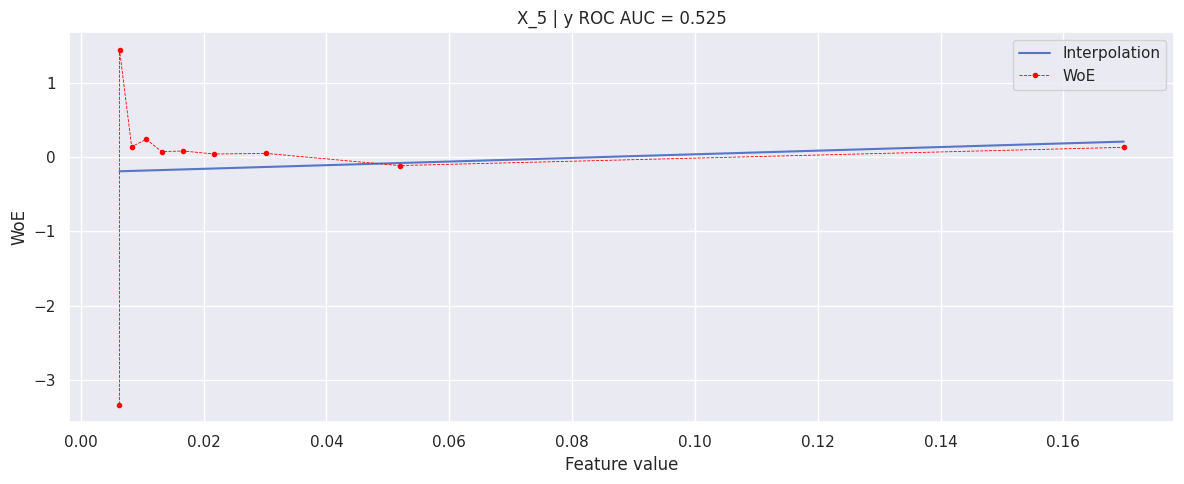

In [216]:
woe_line(np.clip(X_train_prep[:, 5],0.0063, 0.175),y_train, n_buckets=10, var_nm="X_5", target_nm="y", plot_hist=False)

Перепробовал много вариантов, получается с натяжкой назвать зависимость линейной, если нагло ограничить концы, но это всё в ущерб ROC AUC. Наверное, лучше оставить 5 признак таким, каким его дал нам make_classification.

Чуть подправим признаки 1, 2 и 3

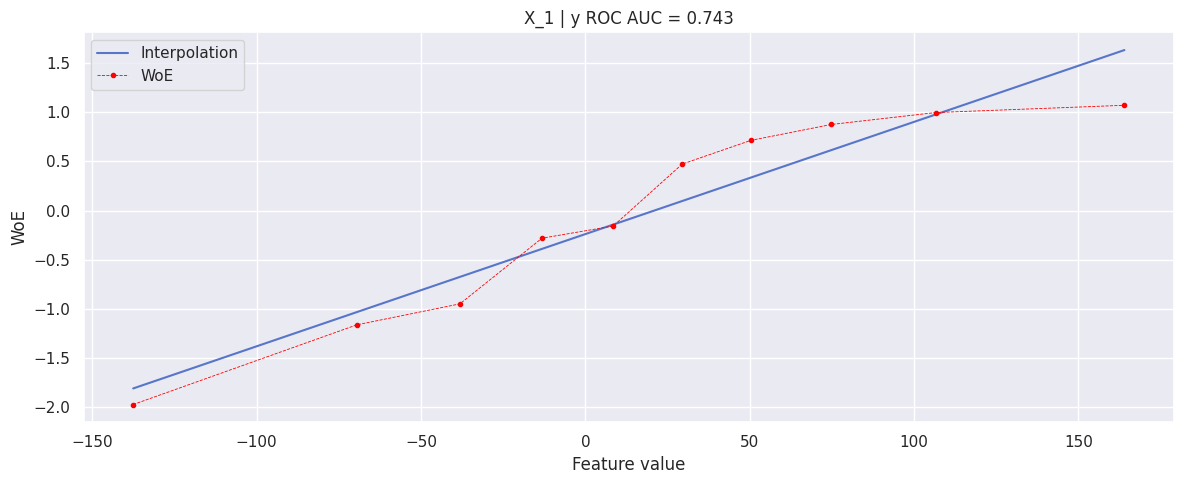

In [220]:
woe_line(X_train_prep[:, 1],y_train, n_buckets=10, var_nm="X_1", target_nm="y", plot_hist=False)

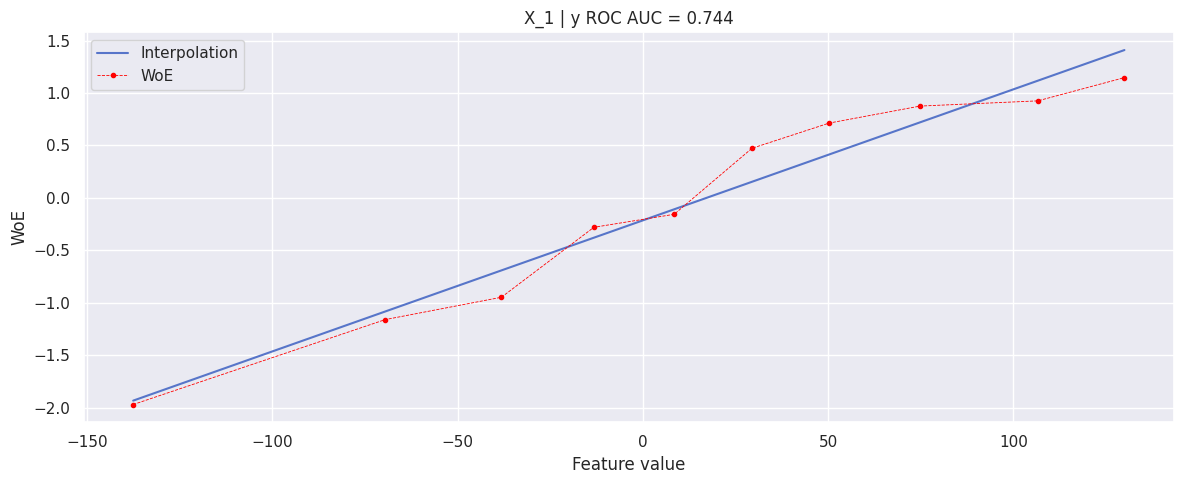

In [227]:
woe_line(np.clip(X_train_prep[:, 1],-150, 130),y_train, n_buckets=10, var_nm="X_1", target_nm="y", plot_hist=False)

Стало чуть лучше, занесем изменения в выборки

In [228]:
X_train_prep[:, 1] = np.clip(X_train_prep[:, 1],-150, 130)
X_test_prep[:, 1] = np.clip(X_test_prep[:, 1],-150, 130)

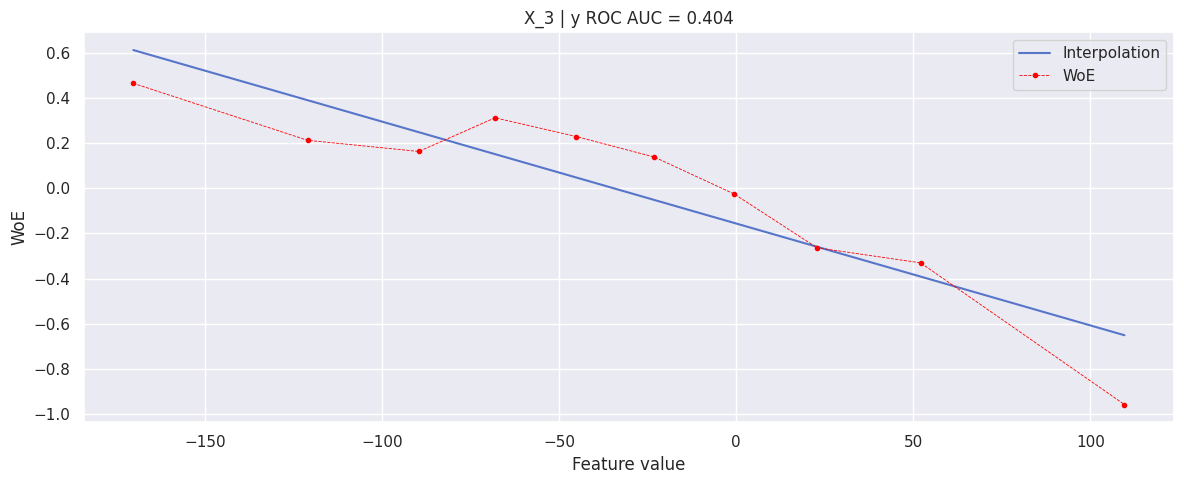

In [249]:
woe_line(X_train_prep[:, 3],y_train, n_buckets=10, var_nm="X_3", target_nm="y", plot_hist=False)

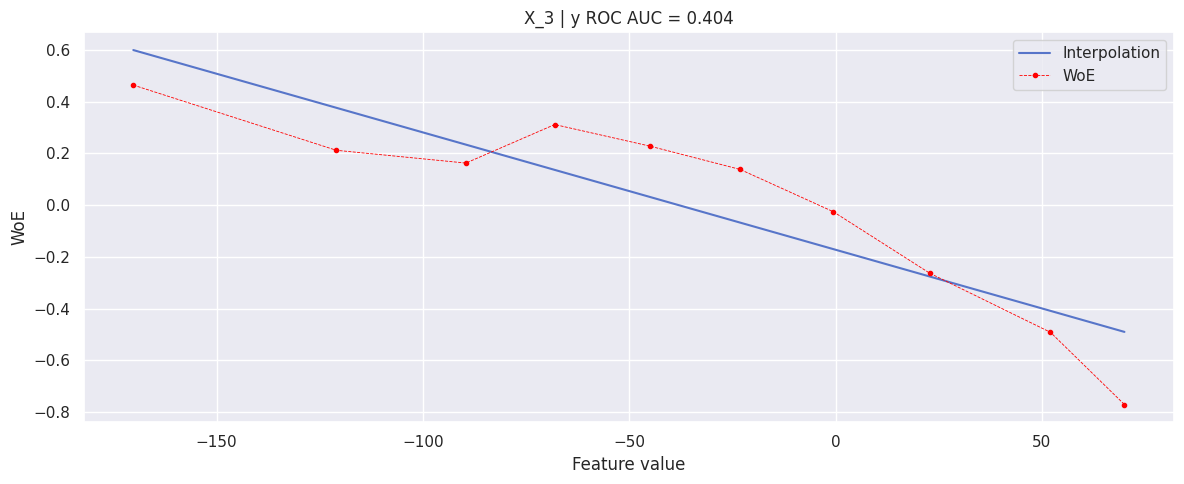

In [257]:
woe_line(np.clip(X_train_prep[:, 3],-200, 70),y_train, n_buckets=10, var_nm="X_3", target_nm="y", plot_hist=False)

In [258]:
X_train_prep[:, 3] = np.clip(X_train_prep[:, 3],-200, 70)
X_test_prep[:, 3] = np.clip(X_test_prep[:, 3],-150, 70)

Удалим все ненужные переменные

In [259]:
unwanted = [0,4,7,8,9,10,11,12,13,14,15,16,17,18,19]
X_train_prep = np.delete(X_train_prep, unwanted, 1)
X_test_prep = np.delete(X_test_prep, unwanted, 1)

Построим модель

In [264]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(random_state=40)
logreg.fit(X_train_prep, y_train)

LogisticRegression(random_state=40)

In [265]:
pred_train_prep = logreg.predict_proba(X_train_prep)[:, 1]
pred_test_prep = logreg.predict_proba(X_test_prep)[:, 1]

print((
    f"ROC AUC на обучающей выборке: {roc_auc_score(y_train, pred_train_prep):.3f}\n"
    f"ROC AUC на тестовой выборке:  {roc_auc_score(y_test, pred_test_prep):.3f}"
))

ROC AUC на обучающей выборке: 0.847
ROC AUC на тестовой выборке:  0.825


## Задание 3

В этом задании предлагается сравнить алгоритм Random Forest с логистической регрессией. Обучите две модели, подобрав гиперпараметры на отделенной от трейна валидационной выборке.

 - на всех признаках из изначального датасета (на сырых данных)
 - на признаках, на которых вы строили логрег (после удаления неинформативных признаков и линеаризации остальных)

Насколько сильнее (или наоборот слабее) показали себя "деревянные модели" по сравнению с линейными? Помогла ли предобработка переменных улучшить качество случайного леса?

# Построение случайного леса

Подберём гиперпараметры для 1 модели (сырые данные) с помощью **RandomizedSearchCV**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state = 40)
from pprint import pprint
print('Parameters currently in use:\n')
pprint(rf.get_params())

In [86]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [ ]:
rfc_tunned = RandomizedSearchCV(estimator=rfc, param_distributions=random_grid,
                              n_iter = 100, scoring='neg_mean_absolute_error', 
                              cv = 3, verbose=2, random_state=40, n_jobs=-1,
                              return_train_score=True)
rfc_tunned.fit(X_train, y_train);

In [88]:
rfc_tunned.best_params_

{'n_estimators': 1000,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 110,
 'bootstrap': False}

In [90]:
best_rfc_raw = rfc_tunned.best_estimator_
pred_train = best_rfc_raw.predict_proba(X_train)[:, 1]
pred_test = best_rfc_raw.predict_proba(X_test)[:, 1]

print((
    f"ROC AUC на обучающей выборке: {roc_auc_score(y_train, pred_train):.3f}\n"
    f"ROC AUC на тестовой выборке:  {roc_auc_score(y_test, pred_test):.3f}"
))

ROC AUC на обучающей выборке: 1.000
ROC AUC на тестовой выборке:  0.936


Теперь сделаем то же самое, но для отобранных признаков

In [267]:
rfc_tunned_prep = RandomizedSearchCV(estimator=rfc, param_distributions=random_grid,
                              n_iter = 100, scoring='neg_mean_absolute_error', 
                              cv = 3, verbose=2, random_state=40, n_jobs=-1,
                              return_train_score=True)
rfc_tunned_prep.fit(X_train_prep, y_train);

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [268]:
best_rfc_prep = rfc_tunned_prep.best_estimator_
pred_train = best_rfc_prep.predict_proba(X_train_prep)[:, 1]
pred_test = best_rfc_prep.predict_proba(X_test_prep)[:, 1]

print((
    f"ROC AUC на обучающей выборке: {roc_auc_score(y_train, pred_train):.3f}\n"
    f"ROC AUC на тестовой выборке:  {roc_auc_score(y_test, pred_test):.3f}"
))

ROC AUC на обучающей выборке: 1.000
ROC AUC на тестовой выборке:  0.906


**Summary** "Деревянные" методы показали себя лучше, причем намного. Предобработка признаков ухудшила результат.

# Дополнительно

Задание 4, опционально

В функции генерации датасета указано $n\_redundant=2$. Это значит, что две переменные получены линейной комбинацией информативных переменных.

Предыдущий анализ никак не исключает появления всех переменных в модели, для этого можно воспользоваться методами отбора признаков.

1. нужно разбить исходную выборку на 3 части: train, val, test, и попробовать подобрать коэффициент $L1$-регуляризации на валидационной выборке. Это должно убрать лишние переменные из модели и повысить таким образом ее стабильность.

Регуляризации в логистической регрессии сильно зависит от стандартного отклонения признака, поэтому стоит воспользоваться нормировкой: sklearn.preprocessing.StandardScaler

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

С нормировкой действуют те же правила: обучается она на train, применяется на val, test

2. подобрать коэффициент $L2$-регуляризации, чтобы избежать слишком больших коэффициентов и улучшить качество на val, test. На этом шаге использовать только те переменные, которые отобраны после п.1

In [ ]:
# your code here